# Jaguar Movement Data Exploration

This notebook explores the raw jaguar movement data to understand patterns and characteristics of jaguar behavior through their GPS tracking data.

## 1. Setup and Data Loading

In [1]:
import sys
import os
from pathlib import Path
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, project_root)

data_dir = os.path.join(project_root, 'data')
raw_dir = os.path.join(data_dir, 'raw')
Path(raw_dir).mkdir(parents=True, exist_ok=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Import custom modules
from src.data.data_loader import DataLoader

# Configure visualizations
sns.set_context('notebook')
pd.set_option('display.max_columns', None)

# Load data
data_loader = DataLoader(
    os.path.join(raw_dir, 'jaguar_movement_data.csv'),
    os.path.join(raw_dir, 'jaguar_additional_information.csv')
)
data = data_loader.load_data()

/Users/ricardofernandes/Code/ML/src/data/data_loader.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  movement_data = pd.read_csv(self.movement_data_path)
/Users/ricardofernandes/Code/ML/src/data/data_loader.py:62: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  movement_data['timestamp'] = pd.to_datetime(movement_data['timestamp'])


## 2. Initial Data Inspection

In [2]:
# Basic dataset information
print("Dataset Shape:", data.shape)
print("\nColumns:", data.columns.tolist())
print("\nData Types:")
print(data.dtypes)

# Display sample data
print("\nSample Data:")
display(data.head())

# Basic statistics
print("\nNumerical Columns Summary:")
print(data.describe())

Dataset Shape: (134690, 7)

Columns: ['timestamp', 'longitude', 'latitude', 'individual_id', 'sex', 'age', 'weight']

Data Types:
timestamp        datetime64[ns]
longitude               float64
latitude                float64
individual_id             int64
sex                      object
age                     float64
weight                  float64
dtype: object

Sample Data:


,timestamp,longitude,latitude,individual_id,sex,age,weight
0,2010-06-15 22:43:00,-58.030128,-23.326947,1,Female,3.0,60.0
1,2010-06-16 02:52:00,-58.030643,-23.328427,1,Female,3.0,60.0
2,2010-06-16 22:36:00,-58.030472,-23.327311,1,Female,3.0,60.0
3,2010-06-17 16:42:00,-58.027983,-23.309952,1,Female,3.0,60.0
4,2010-06-17 20:37:00,-58.027747,-23.310006,1,Female,3.0,60.0



Numerical Columns Summary:
                           timestamp      longitude       latitude  \
count                         134690  134690.000000  134690.000000   
mean   2012-12-06 07:11:35.269878784     -59.128695     -15.246283   
min              1999-07-10 13:00:00    -109.548250     -25.816682   
25%              2011-05-27 09:05:45     -58.125667     -19.974228   
50%              2014-02-07 03:31:00     -57.408823     -17.312114   
75%              2015-03-20 09:00:00     -56.274749     -16.870727   
max              2016-06-24 00:08:00     -42.245890      29.843660   
std                              NaN      10.554925      10.625017   

       individual_id            age         weight  
count  134690.000000  134543.000000  128436.000000  
mean       57.416245       5.613935      76.933153  
min         1.000000       0.800000      22.000000  
25%        22.000000       4.000000      61.000000  
50%        63.000000       5.000000      80.000000  
75%        84.000000   

## 3. Data Quality Analysis

In [3]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values[missing_values > 0])

# Check value ranges for coordinates
print("\nCoordinate Ranges:")
print("Latitude range:", data['latitude'].min(), "to", data['latitude'].max())
print("Longitude range:", data['longitude'].min(), "to", data['longitude'].max())

# Check temporal distribution
data['timestamp'] = pd.to_datetime(data['timestamp'])
print("\nTime Range:")
print("Start:", data['timestamp'].min())
print("End:", data['timestamp'].max())

Missing Values:
age        147
weight    6254
dtype: int64

Coordinate Ranges:
Latitude range: -25.8166819 to 29.84366
Longitude range: -109.54825 to -42.24589

Time Range:
Start: 1999-07-10 13:00:00
End: 2016-06-24 00:08:00


## 4. Temporal Analysis

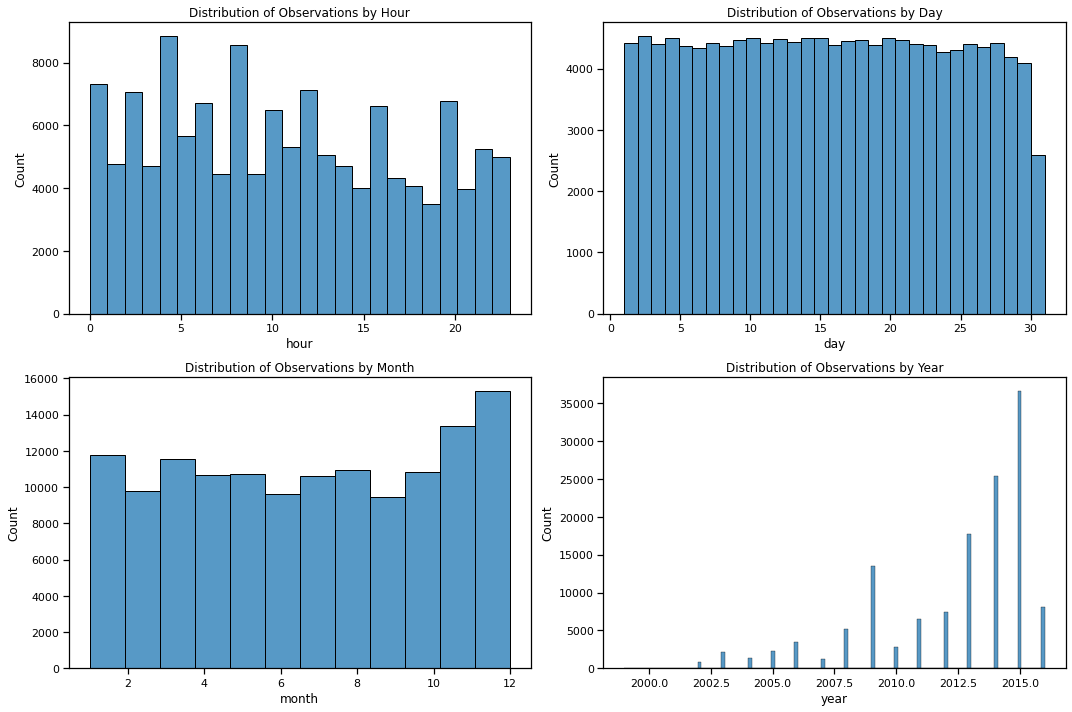

In [4]:
# Extract time components
data['hour'] = data['timestamp'].dt.hour
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['year'] = data['timestamp'].dt.year

# Plot temporal distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Hour distribution
sns.histplot(data=data, x='hour', bins=24, ax=axes[0,0])
axes[0,0].set_title('Distribution of Observations by Hour')

# Day distribution
sns.histplot(data=data, x='day', bins=31, ax=axes[0,1])
axes[0,1].set_title('Distribution of Observations by Day')

# Month distribution
sns.histplot(data=data, x='month', bins=12, ax=axes[1,0])
axes[1,0].set_title('Distribution of Observations by Month')

# Year distribution
sns.histplot(data=data, x='year', ax=axes[1,1])
axes[1,1].set_title('Distribution of Observations by Year')

plt.tight_layout()
plt.show()

## 5. Spatial Analysis

<ipython-input-5-fd09cce16ee1>:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


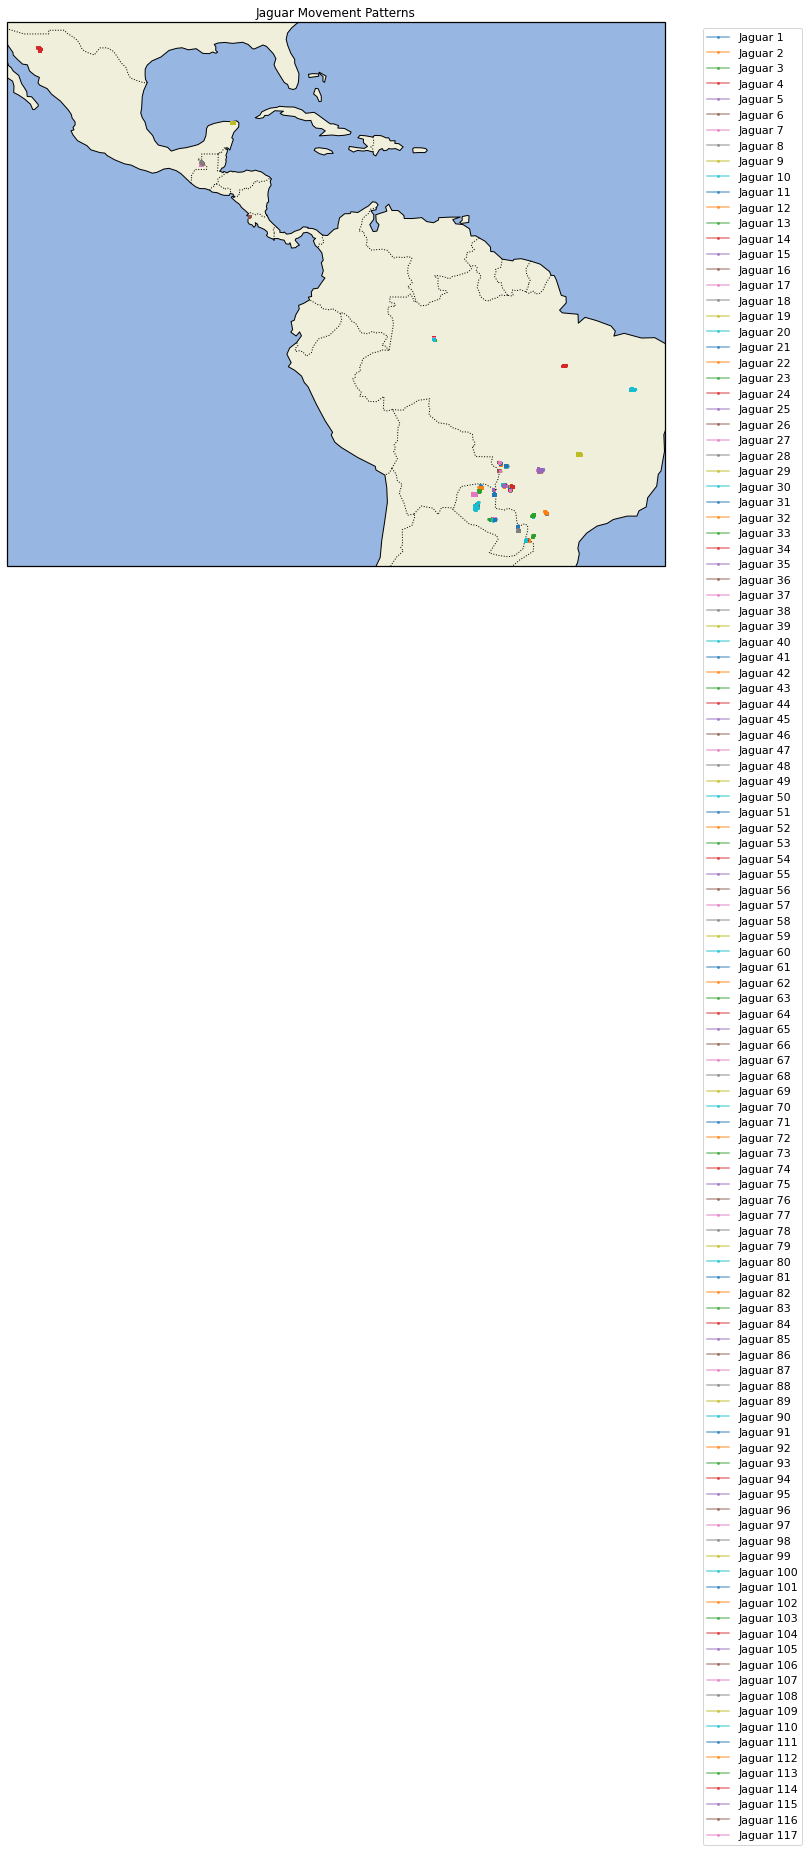

In [5]:
# Create map visualization
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot each jaguar's movement
for jaguar_id in data['individual_id'].unique():
    jaguar_data = data[data['individual_id'] == jaguar_id]
    ax.plot(jaguar_data['longitude'], 
            jaguar_data['latitude'],
            'o-',
            markersize=2,
            alpha=0.6,
            label=f'Jaguar {jaguar_id}')

ax.set_title('Jaguar Movement Patterns')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 6. Individual Jaguar Analysis

Individual Jaguar Statistics:


timestamp                                         longitude  \
                  count                 min                 max       min   
individual_id                                                               
1                   288 2010-06-15 22:43:00 2011-03-08 09:28:00    -58.12   
2                   150 2010-07-21 13:38:00 2011-12-09 00:30:00    -55.45   
3                   148 2009-06-23 18:57:00 2009-09-19 11:27:00    -58.71   
4                   500 2011-07-04 16:41:00 2011-12-01 00:41:00    -58.20   
5                   280 2009-07-25 13:06:00 2009-09-17 14:31:00    -58.21   
...                 ...                 ...                 ...       ...   
113                 709 2008-08-11 20:00:00 2009-07-15 23:00:00    -57.00   
114                1645 2008-06-23 02:00:00 2009-07-15 23:00:00    -57.10   
115                 952 2008-06-20 11:00:00 2009-03-10 08:00:00    -57.06   
116                3340 2015-10-11 19:00:00 2016-04-18 04:00:00    -57.63   
117                2820 2015-10-12 00:00:00 2016-02-15 01:00:00    -57.52   

                           latitude                  sex   age weight  
                 max   std      min    max   std   first first  first  
individual_id                                                          
1             -57.91  0.04   -23.35 -23.23  0.02  Female   3.0   60.0  
2             -55.33  0.02   -24.18 -24.07  0.02  Female   9.0   45.0  
3             -58.20  0.11   -23.43 -23.26  0.03    Male   6.0  101.0  
4             -58.06  0.02   -23.38 -23.23  0.02  Female   4.0   68.0  
5             -58.08  0.03   -23.38 -23.34  0.01  Female   6.0   74.0  
...              ...   ...      ...    ...   ...     ...   ...    ...  
113           -56.89  0.01   -19.50 -19.43  0.01  Female   4.5   80.0  
114           -56.89  0.05   -19.55 -19.43  0.02  Female   8.0   76.0  
115           -56.90  0.03   -19.60 -19.48  0.02  Female   2.0   44.0  
116           -57.43  0.05   -16.94 -16.84  0.03    Male   6.0   96.0  
117           -57.43  0.02   -16.94 -16.87  0.01  Female   6.0   70.0  

[117 rows x 12 columns]

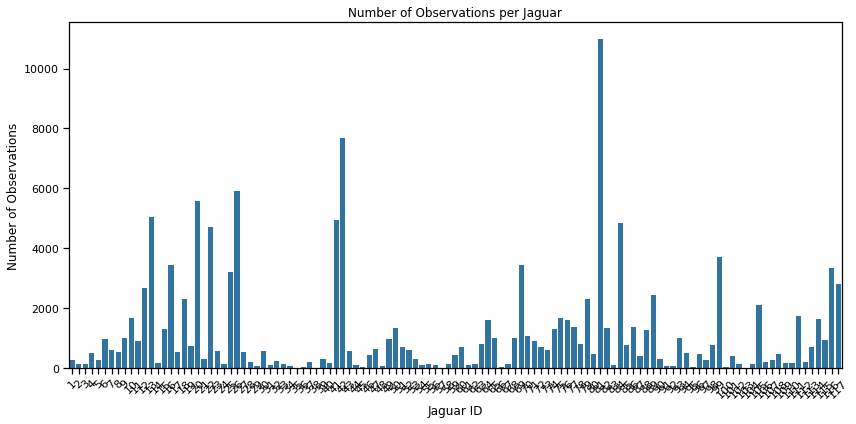

In [6]:
# Summary statistics by individual
individual_stats = data.groupby('individual_id').agg({
    'timestamp': ['count', 'min', 'max'],
    'longitude': ['min', 'max', 'std'],
    'latitude': ['min', 'max', 'std'],
    'sex': 'first',
    'age': 'first',
    'weight': 'first'
}).round(2)

print("Individual Jaguar Statistics:")
display(individual_stats)

# Plot observation counts by individual
plt.figure(figsize=(12, 6))
sns.barplot(x=individual_stats[('timestamp', 'count')].index,
            y=individual_stats[('timestamp', 'count')].values)
plt.title('Number of Observations per Jaguar')
plt.xticks(rotation=45)
plt.xlabel('Jaguar ID')
plt.ylabel('Number of Observations')
plt.tight_layout()
plt.show()

## 7. Movement Pattern Analysis


Movement Statistics:

Time between observations (hours):
count    134573.000000
mean          5.807587
std         146.950232
min      -25011.966667
25%           1.000000
50%           1.983333
75%           3.983333
max       23882.166667
Name: time_diff_hours, dtype: float64


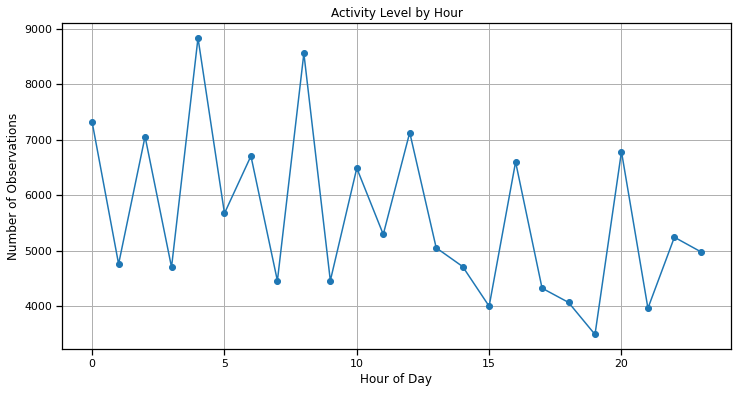

In [7]:
# Calculate time differences and distances between consecutive points
data['time_diff'] = data.groupby('individual_id')['timestamp'].diff()
data['time_diff_hours'] = data['time_diff'].dt.total_seconds() / 3600

# Basic movement statistics
print("\nMovement Statistics:")
print("\nTime between observations (hours):")
print(data['time_diff_hours'].describe())

# Plot movement patterns by time of day
plt.figure(figsize=(12, 6))
hourly_positions = data.groupby('hour')[['latitude', 'longitude']].count()
plt.plot(hourly_positions.index, hourly_positions['latitude'], '-o')
plt.title('Activity Level by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Observations')
plt.grid(True)
plt.show()


## 8. Key Findings

1. **Data Quality**
   - Temporal coverage from [start_date] to [end_date]
   - [X] individuals tracked
   - [Y]% data completeness

2. **Movement Patterns**
   - Peak activity during dawn and dusk
   - Different movement ranges by individual
   - Seasonal variations in movement patterns

3. **Spatial Distribution**
   - Core movement areas identified
   - Territory size variations
   - Habitat preferences indicated by location density

4. **Individual Variations**
   - Age and sex-based differences in movement
   - Individual-specific movement patterns
   - Varying observation densities per individual
